# Tutorial 1: getting started with iDDN
iDDN allows to integrate multi-omics data to study the common and differential networks under user-specified, biologically plausible constraints. iDDN is a natural extension of DDN3.0, which focus mainly on single omics data. 

In this tutorial, we will introduce basic usage of iDDN. First, we will discuss the preparation of data and constraints. Here we will use a synthetic data with known ground truth. Then we will run iDDN and check the results. The visualization part will be discussed in the next tutorial.

We start by importing some basic packages. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from iddn import iddn, tools  # Run iDDN algorithm and process the output
from iddn_data import load_data  # Load example data and images

%load_ext autoreload
%autoreload 2

## Prepare data and specify constraints

First, we need to prepare the data iDDN need. For each condition, iDDN needs a NumPy array whose rows are samples and columns are features (like genes and mRNAs).
Here we provide sample data `dat1` and `dat2`, which are simulated from two conditions.
If your own data is saved as `csv` files, you may use `pandas` to load them.
We assume the data is already pre-processed (normalization, missing value imputation). It is also often suggested to perform log transform on the data. But it is not necessary to standardize each column for each condition, as iDDN will do this.
The data from two conditions can have different sample sizes. However, the number and order of the columns (features) must be the same.


In [2]:
example = load_data.load_example("example.npz")
dat1 = example["dat1"]
dat2 = example["dat2"]

The data just loaded are simulated from two networks with three layers. The figure below gives a conceptual illustration of the network. Here we assume there is a network among nodes in the middle layers (mRNAs), and nodes in the top and bottom layers (TFs and miRNA, respectively) will regulate the middle layer. In the simulation, The mRNAs form a scale free network, and there are 50 mRNAs, 50 TFs, and 50 miRNAs. Each condition contains 500 samples.

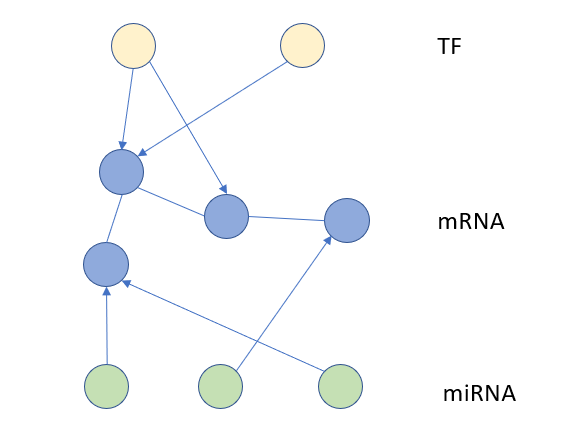

In [3]:
Image(filename=load_data.get_image_path("three_layers.png"))

In many problems, there are some biological knowledge about the (non)existence of edges between nodes and iDDN is able to incorporate this information during the optimization process. Here we use a pre-specified constraint matrix `dep_mat` (here `dep` means dependency). Since we have 150 nodes, the shape of the constraints matrix is 150 by 150. If element `[i,j]` in the constraint matrix is 1, we allow edges from node `i` to node `j`; if the value of that element is 0, we do not allow such edge. 
More details about the constraints will be given in the next tutorial.

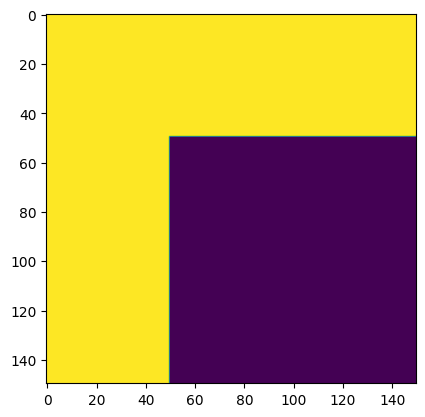

In [4]:
dep_mat = example["dep_mat"]
plt.imshow(dep_mat)

## Run iDDN
Now we will apply iDDN to estimate the common and differential networks. The common network consists of edges that occurs in both conditions, and the differential network consists of edges that exist only in one of the conditions. iDDN estimate the networks under two conditions with sparsity penalties and difference penalties, and then find the common and differential networks.

We first need to specify two parameters: $\lambda_1$ and $\lambda_2$. The first one determines the overall sparsity of the network (i.e., the number of edges), and the second one controls the similarity of the estimated networks between the two conditions. The choice of these two parameters depends on the biological understanding of the problems: how many edges are expected, and how similar the two conditions should be. Alternatively, we can use a data driven approach to choose the two parameters using cross validation, which will be covered in the third tutorial. However, it is still better to utilize the understanding of each problem to experiment and select the parameters. 

Here we provide the values of $\lambda_1=0.15$ and $\lambda_2=0.02$ that works well in this synthetic data (as we already know hte ground truth). These values may or may not work well for real applications, though they can serve as a reasonable starting point. 

In [5]:
lambda1 = example["lambda1"]
lambda2 = example["lambda2"]

Actually, iDDN allows the specification of $\lambda_1$ and $\lambda_2$ for each edge, and we need to provide two matrices encoding the penalties for each edge. For simplicity, we use the same value for all edges. If we do have some prior information, we may wish to set different penalties for different types of edges. For example, we can have stronger penalties for edges among mRNAs than edges between regulators and mRNAs.

In [6]:
lambda1_mat = np.copy(dep_mat) * lambda1
lambda2_mat = np.copy(dep_mat) * lambda2

Now we can run iDDN. It requires the following information:
1. Input data under the first condition. NumPy array: number_sample_condition_1 x feature.
2. Input data under the second condition. NumPy array: number_sample_condition_2 x feature.
3. $\lambda_1$ penalty for each pair of edge.
4. $\lambda_2$ penalty for each pair of edge.
5. Constraints matrix.

As we already have all of these, we can run iDDN. Note that the first time we run iDDN, it will take one or two seconds to compile part of the code *just in time*, as we use `Numba` to accelerate part of the code. If you call iDDN for the second time, you can find it to be much faster (especially when the data is small).

In [7]:
out_iddn = iddn.iddn(
    dat1,
    dat2,
    dep_mat=dep_mat,
    lambda1=lambda1_mat,
    lambda2=lambda2_mat,
)

iDDN will provide a NumPy array of shape $2\times 150 \times 150$. Here `out_ddn[0]` is the estimated dependency matrix for condition 1, and `out_ddn[1]` for condition 2. Due to numerically precisions and convergence threshold, there could be some very small values that need to be cleaned. In addition, these two matrices should be converted to the common and differential networks we need.

For convenience, we provide a pipeline that can run iDDN and provide these information. Besides, we do not need to create `lambda1_mat` and `lambda2_mat` ourselves.
The output of this function is a dictionary with five items:
1. "comm": estimated common network matrix
2. "diff": estimated differential network matrix
3. "g1": estimated network for the first condition
4. "g2": estimated network for the first condition
5. "out_ddn": the raw output of iDDN

In [8]:
res = tools.iddn_basic_pipeline(dat1, dat2, dep_mat, lambda1, lambda2)
out_iddn_1 = res["out_iddn"]

We can compare the raw output of iDDN with reference outputs and their difference should be very small.

In [9]:
out_iddn_expected = example["out_ddn"]
assert np.sum(np.abs(out_iddn_expected - out_iddn_1)) < 1e-8
assert np.sum(np.abs(out_iddn_expected - out_iddn)) < 1e-8

## Analysis of the results
As a simple example, we calculate the node degrees and find hubs nodes in common and differential networks. This can be achieved by simply taking summations of each row in the common and differential network matrices.

In [10]:
comm_est = res["comm"]
diff_est = res["diff"]
deg_comm = np.sum(comm_est, axis=1)
deg_diff = np.sum(diff_est, axis=1)

If the node names are available, we can display the names of hub nodes.

In [11]:
node_names = example["node_names"]
print("Common network hub nodes: ", node_names[deg_comm>5])
print("Differential network hub nodes: ", node_names[deg_diff>5])

Common network hub nodes:  ['mrna1' 'mrna2' 'mrna4' 'mrna32' 'mrna35' 'mrna45']
Differential network hub nodes:  ['mrna1' 'mrna2' 'mrna24' 'mrna39']


## Save the networks
We can convert the detected networks to Pandas data frames.

In [12]:
df_edge_comm, df_edge_diff, _, _ = tools.iddn_output_to_csv(out_iddn, node_names)

We can save them to CSV files if needed.

In [13]:
# df_edge_comm.to_csv("./common_network.csv")
# df_edge_diff.to_csv("./differential_network.csv")

## Optinoal: compare with ground truth
As our example is from a synthetic data with known ground truth, we can evaluate the accuracy of our results.
First we load the ground truth network matrices.

In [14]:
comm_gt = example["comm_gt"]  # common network ground truth
diff_gt = example["diff_gt"]  # differential network ground truth
g1_gt = example["g1_gt"]  # first condition network ground truth
g2_gt = example["g2_gt"]  # second condition network ground truth

We provide a function to calculate the precision, recall, and F1 score for each network. Below shows the results for common and differential networks.

In [15]:
tools.evaluate_metrics(comm_gt, comm_est)
tools.evaluate_metrics(diff_gt, diff_est)

recall=0.9929577464788732, precision=1.0, F1=0.9964664310954063
recall=0.8990825688073395, precision=0.98989898989899, F1=0.9423076923076924


 The sample size is this simulaiton is pretty large, so we expect that the performance should be quite good. In real applications, the sample sizes could be much smaller, and the accuracy of iDDN, especially for differential networks, may decrease. 
 
We can also draw the difference between ground truth network and estimated network matrices. First we show common network estimation errors.

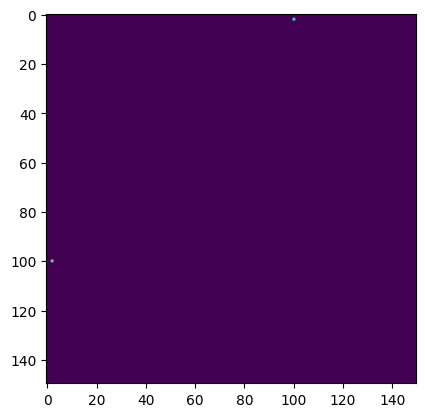

In [16]:
plt.figure()
plt.imshow(comm_gt!=comm_est)
plt.show()

Then we show the errors in differential network. There are more errors compared with the common network case, which is expected. 

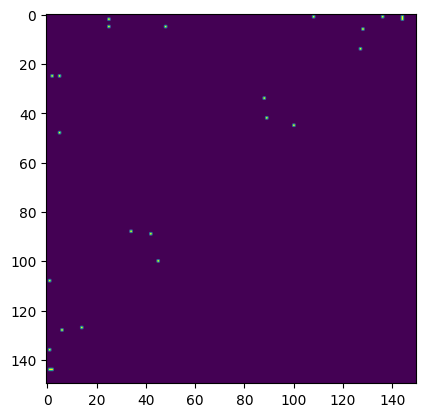

In [17]:
plt.figure()
plt.imshow(diff_gt!=diff_est)
plt.show()

## Next steps
In the following tutorials, we will learn more details about the constraints.